In [2]:
# importing libraries
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import metrics
import gc
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error,accuracy_score, r2_score, make_scorer,log_loss
from sklearn.model_selection import KFold


In [3]:
# Reading ratings file
ratings = pd.read_csv('Dataset/ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id','movie_id','rating','timestamp'])

# Reading movies file
movies = pd.read_csv('Dataset/movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id','title','genres'])

In [4]:
df_movies = movies 
df_ratings = ratings

In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
movie_id    3883 non-null int64
title       3883 non-null object
genres      3883 non-null object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [6]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
df_ratings.head(10)

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


In [8]:
df_movies.isnull().values.any()

False

In [9]:
df_ratings.isnull().values.any()

False

In [16]:
plt.figure(figsize=(20,7))
generlist = df_movies['genres'].apply(lambda generlist_movie : str(generlist_movie).split("|"))
geners_count = {}

for generlist_movie in generlist:
    for gener in generlist_movie:
        if(geners_count.get(gener,False)):
            geners_count[gener]=geners_count[gener]+1
        else:
            geners_count[gener] = 1       
geners_count.pop("(no genres listed)")
plt.bar(geners_count.keys(),geners_count.values(),color='b')

KeyError: '(no genres listed)'

<Figure size 1440x504 with 0 Axes>

/Users/sarthakgoel/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


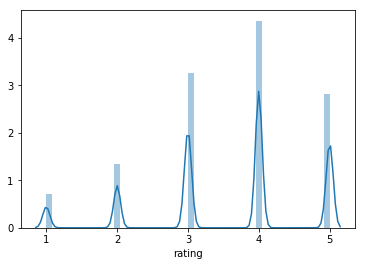

In [11]:
sns.distplot(df_ratings["rating"]);

In [15]:
df_ratings["No.RatingsPerUser"] = df_ratings.groupby('user_id')['user_id'].transform('count')


In [13]:
df_ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [17]:
import numpy as np
from lightfm.datasets import fetch_movielens
from lightfm import LightFM

/Users/sarthakgoel/anaconda3/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [20]:
#fetch data and format
data = fetch_movielens(min_rating = 0.5)

#print training and testing data
print(repr(data['train']))
print(repr(data['test']))

<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 90570 stored elements in COOrdinate format>
<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 9430 stored elements in COOrdinate format>


In [21]:
data

{'train': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 90570 stored elements in COOrdinate format>,
 'test': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 9430 stored elements in COOrdinate format>,
 'item_features': <1682x1682 sparse matrix of type '<class 'numpy.float32'>'
 	with 1682 stored elements in Compressed Sparse Row format>,
 'item_feature_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object),
 'item_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object)}

In [22]:
#create model
model = LightFM(loss='warp')
#train model
model.fit(data['train'], epochs = 30, num_threads=2)

In [23]:
def sample_recommendation(model, data, user_ids):

    #number of users and movies in training data
    n_users, n_items = data['train'].shape

    #generate recommendations for each user input
    for user_id in user_ids: 

        #movies they always like
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]

        #movies the model predicts they will like
        scores = model.predict(user_id, np.arange(n_items))
        #rank in order of most liked to least
        top_items = data['item_labels'][np.argsort(-scores)]

        #print results
        print("User %s" % user_id)
        print("         Known positives:")

        for x in known_positives[:3]:
            print("          %s" % x)
        
        print("         Recommend:")

        for x in top_items[:3]:
            print("         %s" % x)

In [25]:
sample_recommendation(model, data, [10, 30, 25, 34, 450])

User 10
         Known positives:
          Babe (1995)
          Dead Man Walking (1995)
          Seven (Se7en) (1995)
         Recommend:
         Raiders of the Lost Ark (1981)
         Star Wars (1977)
         Empire Strikes Back, The (1980)
User 30
         Known positives:
          Crumb (1994)
          Fugitive, The (1993)
          Lone Star (1996)
         Recommend:
         English Patient, The (1996)
         Full Monty, The (1997)
         L.A. Confidential (1997)
User 25
         Known positives:
          Toy Story (1995)
          Twelve Monkeys (1995)
          Dead Man Walking (1995)
         Recommend:
         Fargo (1996)
         Independence Day (ID4) (1996)
         Scream (1996)
User 34
         Known positives:
          Contact (1997)
          Mimic (1997)
          Kull the Conqueror (1997)
         Recommend:
         Dante's Peak (1997)
         Saint, The (1997)
         Scream (1996)
User 450
         Known positives:
          Kolya (1996)
        

In [28]:
from sklearn.metrics import roc_auc_score
from lightfm.evaluation import auc_score
auc_train = auc_score(model, data['train']).mean()
auc_test = auc_score(model, data['test']).mean()

In [29]:
print("Train AUC Score: {}".format(auc_train))
print("Test AUC Score: {}".format(auc_test))

Train AUC Score: 0.9468595385551453
Test AUC Score: 0.9083220958709717


## K-Mean Clustering

In [11]:
movies.groupby('genres')['movie_id']

In [12]:
movies.genres.unique()

array(["Animation|Children's|Comedy", "Adventure|Children's|Fantasy",
       'Comedy|Romance', 'Comedy|Drama', 'Comedy',
       'Action|Crime|Thriller', "Adventure|Children's", 'Action',
       'Action|Adventure|Thriller', 'Comedy|Drama|Romance',
       'Comedy|Horror', "Animation|Children's", 'Drama',
       'Action|Adventure|Romance', 'Drama|Thriller', 'Drama|Romance',
       'Thriller', 'Action|Comedy|Drama', 'Crime|Drama|Thriller',
       'Drama|Sci-Fi', 'Romance', 'Adventure|Sci-Fi', 'Adventure|Romance',
       "Children's|Comedy|Drama", 'Documentary', 'Drama|War',
       'Action|Crime|Drama', 'Action|Adventure', 'Crime|Thriller',
       "Animation|Children's|Musical|Romance", 'Action|Drama|Thriller',
       "Children's|Comedy", 'Drama|Mystery', 'Sci-Fi|Thriller',
       'Action|Comedy|Crime|Horror|Thriller', 'Drama|Musical',
       'Crime|Drama|Romance', 'Adventure|Drama', 'Action|Thriller',
       "Adventure|Children's|Comedy|Musical", 'Action|Drama|War',
       'Action|Adventur

In [21]:
# Make a census of the genre keywords
genre_labels = set()
for s in df_movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [22]:
keyword_occurences, dum = count_word(df_movies, 'genres', genre_labels)
keyword_occurences[:100]

[['Drama', 1603],
 ['Comedy', 1200],
 ['Action', 503],
 ['Thriller', 492],
 ['Romance', 471],
 ['Horror', 343],
 ['Adventure', 283],
 ['Sci-Fi', 276],
 ["Children's", 251],
 ['Crime', 211],
 ['War', 143],
 ['Documentary', 127],
 ['Musical', 114],
 ['Mystery', 106],
 ['Animation', 105],
 ['Fantasy', 68],
 ['Western', 68],
 ['Film-Noir', 44]]

In [28]:
def movie_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movie_id'].isin(genre_movies['movie_id'])].loc[:, ['user_id', 'rating']].groupby(['user_id'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    print(genre_ratings)
    genre_ratings.columns = column_names
    return genre_ratings

In [29]:
genre_ratings = movie_genre_ratings(ratings, movies, ['Romance','Drama','Action','Crime','War','Comedy','Thriller','Horror','Adventure','Documentary','Musical','Mysetry','Animation','Fantasy','Western','Film-Noir', 'Sci-Fi'], ['avg_romance_rating', 'avg_Drama_rating','avg_Action_rating','avg_Crime_rating','avg_War_rating','avg_Comedy_rating','avg_Thriller_rating','avg_Horror_rating','avg_Adventure_rating','avg_Documentary_rating','avg_Musical_rating','avg_Mysetry_rating','avg_Animation_rating','avg_Fantasy_rating','avg_Western_rating','avg_Film-Noir_rating','avg_Sci-Fi_rating'])
genre_ratings.head()

         rating  rating  rating  rating  rating  rating  rating  rating  \
user_id                                                                   
1          3.67    4.43    4.20    4.00    5.00    4.14    3.67     NaN   
2          3.71    3.90    3.50    3.58    3.73    3.56    3.48    3.00   
3          3.80    4.00    3.96     NaN    4.00    3.77    3.80    2.67   
4          4.00    4.17    4.16    5.00    3.33     NaN    3.50    4.33   
5          3.10    3.10    2.61    3.29    3.50    3.41    2.85    2.80   
6          4.00    3.73    4.00    3.00    4.00    3.75    3.67     NaN   
7          4.00    4.00    4.31    4.00    4.75    4.33    4.60    5.00   
8          4.07    3.81    4.03    4.00    4.20    3.89    4.03    5.00   
9          3.56    3.89    3.50    3.75    4.14    3.74    3.63    2.00   
10         4.37    4.18    3.91    3.60    3.83    4.14    4.22    4.00   
11         3.09    3.69    3.56    4.43    3.75    3.17    3.44    3.00   
12         3.00    4.33  

,avg_romance_rating,avg_Drama_rating,avg_Action_rating,avg_Crime_rating,avg_War_rating,avg_Comedy_rating,avg_Thriller_rating,avg_Horror_rating,avg_Adventure_rating,avg_Documentary_rating,avg_Musical_rating,avg_Mysetry_rating,avg_Animation_rating,avg_Fantasy_rating,avg_Western_rating,avg_Film-Noir_rating,avg_Sci-Fi_rating
user_id,,,,,,,,,,,,,,,,,
1,3.67,4.43,4.20,4.00,5.00,4.14,3.67,NaN,4.00,NaN,4.29,NaN,4.11,4.0,NaN,NaN,4.33
2,3.71,3.90,3.50,3.58,3.73,3.56,3.48,3.00,3.74,NaN,NaN,NaN,NaN,3.0,4.33,4.0,3.59
3,3.80,4.00,3.96,NaN,4.00,3.77,3.80,2.67,4.00,NaN,4.00,NaN,4.00,4.5,4.67,NaN,3.83
4,4.00,4.17,4.16,5.00,3.33,NaN,3.50,4.33,3.83,NaN,NaN,NaN,NaN,4.5,4.50,NaN,3.56
5,3.10,3.10,2.61,3.29,3.50,3.41,2.85,2.80,3.00,3.67,3.33,NaN,4.00,NaN,4.00,4.0,3.07


In [56]:
avg_FilmNoir_rating_array = genre_ratings[genre_ratings["avg_Film-Noir_rating"]!=np.nan]["avg_Film-Noir_rating"]
genre_ratings['avg_Film-Noir_rating']=genre_ratings["avg_Film-Noir_rating"].replace(np.nan,avg_FilmNoir_rating_array.mean())

In [58]:
avg_SciFi_rating_array = genre_ratings[genre_ratings["avg_Sci-Fi_rating"]!=np.nan]["avg_Sci-Fi_rating"]
genre_ratings['avg_Sci-Fi_rating']=genre_ratings["avg_Sci-Fi_rating"].replace(np.nan,avg_SciFi_rating_array.mean())

In [ ]:
avg_Western_rating_array = genre_ratings[genre_ratings["avg_Western_rating"]!=np.nan]["avg_Western_rating"]
genre_ratings['avg_Western_rating']=genre_ratings["avg_Western_rating"].replace(np.nan,avg_Western_rating_array.mean())

In [ ]:
avg_Fantasy_rating_array = genre_ratings[genre_ratings["avg_Fantasy_rating"]!=np.nan]["avg_Fantasy_rating"]
genre_ratings['avg_Fantasy_rating']=genre_ratings["avg_Fantasy_rating"].replace(np.nan,avg_Fantasy_rating_array.mean())

In [ ]:
avg_Animation_rating_array = genre_ratings[genre_ratings["avg_Animation_rating"]!=np.nan]["avg_Animation_rating"]
genre_ratings['avg_Animation_rating']=genre_ratings["avg_Animation_rating"].replace(np.nan,avg_Animation_rating_array.mean())

In [ ]:
avg_Musical_rating_array = genre_ratings[genre_ratings["avg_Musical_rating"]!=np.nan]["avg_Musical_rating"]
genre_ratings['avg_Musical_rating']=genre_ratings["avg_Musical_rating"].replace(np.nan,avg_Musical_rating_array.mean())

In [47]:
avg_Documentary_rating_array = genre_ratings[genre_ratings["avg_Documentary_rating"]!=np.nan]["avg_Documentary_rating"]
genre_ratings['avg_Documentary_rating']=genre_ratings["avg_Documentary_rating"].replace(np.nan,avg_Documentary_rating_array.mean())

In [ ]:
avg_Adventure_rating_array = genre_ratings[genre_ratings["avg_Adventure_rating"]!=np.nan]["avg_Adventure_rating"]
genre_ratings['avg_Adventure_rating']=genre_ratings["avg_Adventure_rating"].replace(np.nan,avg_Adventure_rating_array.mean())

In [ ]:
avg_Horror_rating_array = genre_ratings[genre_ratings["avg_Horror_rating"]!=np.nan]["avg_Horror_rating"]
genre_ratings['avg_Horror_rating']=genre_ratings["avg_Horror_rating"].replace(np.nan,avg_Horror_rating_array.mean())

In [ ]:
avg_Thriller_rating_array = genre_ratings[genre_ratings["avg_Thriller_rating"]!=np.nan]["avg_Thriller_rating"]
genre_ratings['avg_Thriller_rating']=genre_ratings["avg_Thriller_rating"].replace(np.nan,avg_Thriller_rating_array.mean())

In [ ]:
avg_Comedy_rating_array = genre_ratings[genre_ratings["avg_Comedy_rating"]!=np.nan]["avg_Comedy_rating"]
genre_ratings['avg_Comedy_rating']=genre_ratings["avg_Comedy_rating"].replace(np.nan,avg_Comedy_rating_array.mean())

In [ ]:
avg_War_rating_array = genre_ratings[genre_ratings["avg_War_rating"]!=np.nan]["avg_War_rating"]
genre_ratings['avg_War_rating']=genre_ratings["avg_War_rating"].replace(np.nan,avg_War_rating_array.mean())

In [ ]:
avg_Crime_rating_array = genre_ratings[genre_ratings["avg_Crime_rating"]!=np.nan]["avg_Crime_rating"]
genre_ratings['avg_Crime_rating']=genre_ratings["avg_Crime_rating"].replace(np.nan,avg_Crime_rating_array.mean())

In [ ]:
avg_Drama_rating_array = genre_ratings[genre_ratings["avg_Drama_rating"]!=np.nan]["avg_Drama_rating"]
genre_ratings['avg_Drama_rating']=genre_ratings["avg_Drama_rating"].replace(np.nan,avg_Drama_rating_array.mean())

In [ ]:
avg_romance_rating_array = genre_ratings[genre_ratings["avg_romance_rating"]!=np.nan]["avg_romance_rating"]
genre_ratings['avg_romance_rating']=genre_ratings["avg_romance_rating"].replace(np.nan,avg_romance_rating_array.mean())

In [ ]:
avg_Action_rating_array = genre_ratings[genre_ratings["avg_Action_rating"]!=np.nan]["avg_Action_rating"]
genre_ratings['avg_Action_rating']=genre_ratings["avg_Action_rating"].replace(np.nan,avg_Action_rating_array.mean())

In [30]:
genre_ratings.isnull().sum()

avg_romance_rating          79
avg_Drama_rating             3
avg_Action_rating           28
avg_Crime_rating           378
avg_War_rating             271
avg_Comedy_rating            9
avg_Thriller_rating         51
avg_Horror_rating          740
avg_Adventure_rating       146
avg_Documentary_rating    3797
avg_Musical_rating        1286
avg_Mysetry_rating        6040
avg_Animation_rating      1232
avg_Fantasy_rating        1190
avg_Western_rating        1940
avg_Film-Noir_rating      1890
avg_Sci-Fi_rating          129
dtype: int64

In [32]:
genre_ratings = genre_ratings.drop(['avg_Mysetry_rating'], axis=1)

In [61]:
genre_ratings.head()

,avg_romance_rating,avg_Drama_rating,avg_Action_rating,avg_Crime_rating,avg_War_rating,avg_Comedy_rating,avg_Thriller_rating,avg_Horror_rating,avg_Adventure_rating,avg_Documentary_rating,avg_Musical_rating,avg_Animation_rating,avg_Fantasy_rating,avg_Western_rating,avg_Film-Noir_rating,avg_Sci-Fi_rating
user_id,,,,,,,,,,,,,,,,
1,3.67,4.43,4.20,4.000000,5.00,4.140000,3.67,3.329908,3.849692,3.849692,4.290000,4.110000,4.000000,3.626505,4.012227,4.33
2,3.71,3.90,3.50,3.580000,3.73,3.560000,3.48,3.000000,3.849692,3.849692,3.682836,3.695711,3.000000,4.330000,4.000000,3.59
3,3.80,4.00,3.96,3.769433,4.00,3.770000,3.80,2.670000,3.849692,3.849692,4.000000,4.000000,4.500000,4.670000,4.012227,3.83
4,4.00,4.17,4.16,5.000000,3.33,3.638193,3.50,4.330000,3.849692,3.849692,3.682836,3.695711,4.500000,4.500000,4.012227,3.56
5,3.10,3.10,2.61,3.290000,3.50,3.410000,2.85,2.800000,3.670000,3.670000,3.330000,4.000000,3.579163,4.000000,4.000000,3.07


In [60]:
from sklearn.cluster import KMeans

kmeans_1 = KMeans(n_clusters=16, random_state=0)

predictions = kmeans_1.fit_predict(genre_ratings)

In [67]:
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_Sci-Fi_rating'], clustered['avg_romance_rating'] ,c=clustered['group'], s=20, cmap=cmap)

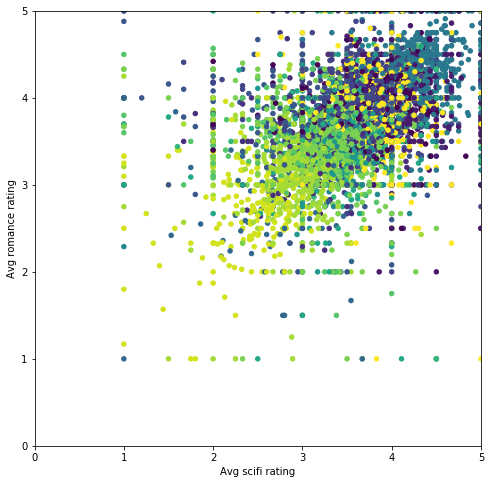

In [68]:
draw_clusters(genre_ratings,predictions,cmap='viridis')

In [73]:
from sklearn.metrics import silhouette_samples, silhouette_score

def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

In [75]:
print(len(genre_ratings)+1)

6041


In [76]:
possible_k_values = range(2, 100, 5)

errors_per_k = [clustering_errors(k, genre_ratings) for k in possible_k_values]

In [77]:
list(zip(possible_k_values, errors_per_k))

[(2, 0.20059256926930125),
 (7, 0.08730000195210083),
 (12, 0.07519105255039138),
 (17, 0.07135023923620107),
 (22, 0.054529872872509544),
 (27, 0.05710799715221756),
 (32, 0.05102484908498062),
 (37, 0.04900444240183123),
 (42, 0.05376275594392306),
 (47, 0.04851245212780303),
 (52, 0.045608269297908434),
 (57, 0.039354866810680324),
 (62, 0.04100793167913867),
 (67, 0.04006864463739387),
 (72, 0.04161207057687175),
 (77, 0.04728508299696214),
 (82, 0.04036186681309694),
 (87, 0.04190977688067044),
 (92, 0.039475553257612504),
 (97, 0.043457118930811944)]

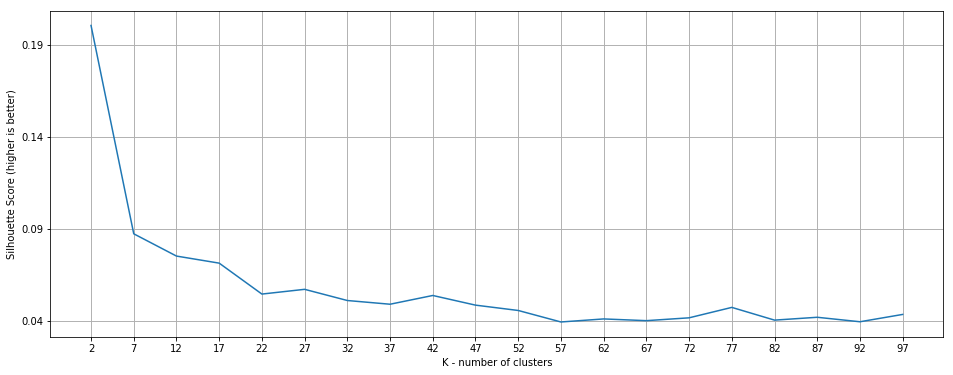

In [78]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlabel('K - number of clusters')
ax.set_ylabel('Silhouette Score (higher is better)')
ax.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

### Movie Based Clustering

In [86]:
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

In [87]:
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

In [88]:
def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    # Get most voting users
    # 1- Count
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # 2- Sort
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    # 3- Slice
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    
    return most_rated_movies_users_selection

In [91]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movie_id', 'title']], on='movie_id' )
user_movie_ratings = pd.pivot_table(ratings_title, index='user_id', columns= 'title', values='rating')

print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (6040, 3706) 

Subset example:


title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957)
user_id,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()

dataset dimensions:  (18, 30)


title,American Beauty (1999),Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode V - The Empire Strikes Back (1980),Star Wars: Episode VI - Return of the Jedi (1983),Jurassic Park (1993),Saving Private Ryan (1998),Terminator 2: Judgment Day (1991),"Matrix, The (1999)",Back to the Future (1985),"Silence of the Lambs, The (1991)",...,E.T. the Extra-Terrestrial (1982),Star Wars: Episode I - The Phantom Menace (1999),Being John Malkovich (1999),"Shawshank Redemption, The (1994)","Godfather, The (1972)",Forrest Gump (1994),Ghostbusters (1984),Pulp Fiction (1994),"Terminator, The (1984)",Toy Story (1995)
4577,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,...,4.0,3.0,5.0,5.0,4.0,5.0,4.0,5.0,5.0,4.0
5053,3.0,5.0,4.0,4.0,5.0,4.0,4.0,3.0,5.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,5.0
4883,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,...,5.0,2.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0
1634,5.0,5.0,5.0,5.0,4.0,5.0,4.0,5.0,4.0,5.0,...,5.0,5.0,5.0,5.0,5.0,3.0,4.0,5.0,4.0,5.0
1631,4.0,5.0,5.0,5.0,3.0,4.0,2.0,2.0,3.0,3.0,...,4.0,5.0,4.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0


In [98]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    
    # Reverse to match the order of the printed dataframe
    #most_rated_movies_users_selection = most_rated_movies_users_selection.iloc[::-1]
    
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')

    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])



    plt.show()

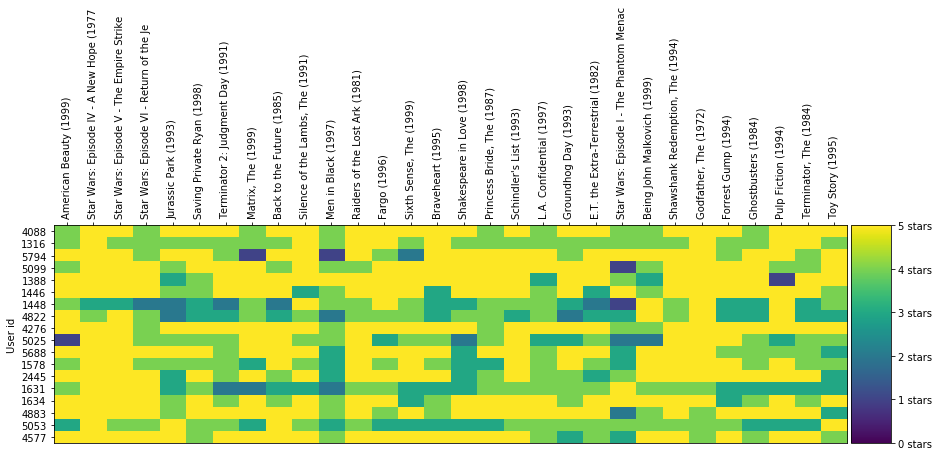

In [99]:
draw_movies_heatmap(most_rated_movies_users_selection)

In [102]:
user_movie_ratings =  pd.pivot_table(ratings_title, index='user_id', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)

In [104]:
from scipy.sparse import csr_matrix
sparse_ratings = csr_matrix(pd.SparseDataFrame(most_rated_movies_1k).to_coo())

In [107]:
# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)

In [109]:
max_users = 70
max_movies = 50

clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

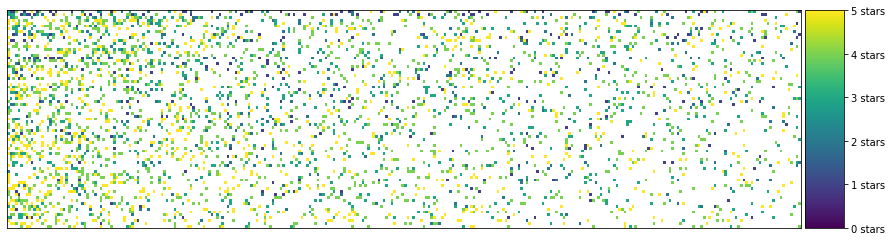

In [110]:
# TODO: Pick a cluster ID from the clusters above
cluster_number = 4

# Let's filter to only see the region of the dataset with the most number of values 
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)

cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)

In [111]:
cluster.fillna('').head()

,American Beauty (1999),Star Wars: Episode VI - Return of the Jedi (1983),Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Saving Private Ryan (1998),Star Wars: Episode V - The Empire Strikes Back (1980),Terminator 2: Judgment Day (1991),"Silence of the Lambs, The (1991)",Star Wars: Episode I - The Phantom Menace (1999),...,Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954),"Grifters, The (1990)",Caddyshack (1980),"Third Man, The (1949)",Like Water for Chocolate (Como agua para chocolate) (1992),"Philadelphia Story, The (1940)",Out of Sight (1998),Full Metal Jacket (1987),Alien³ (1992),Starship Troopers (1997)
489,3,1,1,4,,,1,,,5,...,,,,,,,,,4,1
1900,3,3,3,,,1,3,1,1,,...,,,,,5,,,,,
857,,2,3,4,,,,,,3,...,3,,,,,,,,,
600,5,,5,,4,,4,4,,,...,,,,,,,,,,
246,5,,,5,4,,,5,5,4,...,5,,,,,,,,1,


In [112]:
movie_name = 'Shakespeare in Love (1998)'

cluster[movie_name].mean()

3.869565217391304